## MLP for predicting next word

In [1]:
# libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [11]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [16]:
# build the dataset

block_size = 3 # context length : how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in  context), "---> ", itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --->  e
..e --->  m
.em --->  m
emm --->  a
mma --->  .
olivia
... --->  o
..o --->  l
.ol --->  i
oli --->  v
liv --->  i
ivi --->  a
via --->  .
ava
... --->  a
..a --->  v
.av --->  a
ava --->  .
isabella
... --->  i
..i --->  s
.is --->  a
isa --->  b
sab --->  e
abe --->  l
bel --->  l
ell --->  a
lla --->  .
sophia
... --->  s
..s --->  o
.so --->  p
sop --->  h
oph --->  i
phi --->  a
hia --->  .


In [17]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [21]:
C = torch.randn((27,2))

In [22]:
C[5]

tensor([-0.2060,  0.2796])

In [24]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([-0.2060,  0.2796])

In [26]:
C[torch.tensor([5,6,7])]

tensor([[-2.0603e-01,  2.7961e-01],
        [-1.8197e+00,  1.3763e-03],
        [-2.1639e+00,  1.1811e-01]])

In [28]:
C[X].shape # for every X we retrieve the weights in 2 dimension

torch.Size([32, 3, 2])

In [30]:
X[13,2]

tensor(1)

In [31]:
C[X][13,2]

tensor([-0.0981, -0.5982])

In [32]:
C[1]

tensor([-0.0981, -0.5982])

In [50]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [41]:
# torch.cat([emd[:,0,:],emd[:,1,:],emd[:,2,:]], 1).shape # combining all the three inputs in one

torch.Size([32, 6])

In [45]:
# torch.cat(torch.unbind(emd, 1),1).shape # inefficient

torch.Size([32, 6])

In [53]:
# first hidden layer weights and bias
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [54]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [56]:
h.shape

torch.Size([32, 100])

In [57]:
# final output layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [58]:
logits = h @ W2 + b2 

In [60]:
counts = logits.exp() # fake counts

In [61]:
prob = counts / counts.sum(1, keepdims = True)

In [62]:
loss = - prob[torch.arange(32),Y].log().mean()
loss

tensor(17.4985)

In [201]:
def build_dataset(words):
    block_size = 3 # context length : how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in  context), "---> ", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [63]:
# ---- -----

In [239]:
# dataset
Xtr.shape, Ytr.shape 

(torch.Size([182625, 3]), torch.Size([182625]))

In [265]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1 ,b1, W2, b2]

In [266]:
sum(p.nelement() for p in parameters) # sum of paramerters in network


11897

In [267]:
for p in parameters:
    p.requires_grad = True

In [206]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre

In [278]:
lri = []
lossi = []
stepi = []

In [279]:
# train the network 

for i in range(50000):
    
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])
   
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update the parameters
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
        
#print(loss.item())

In [274]:
len(stepi)

100000

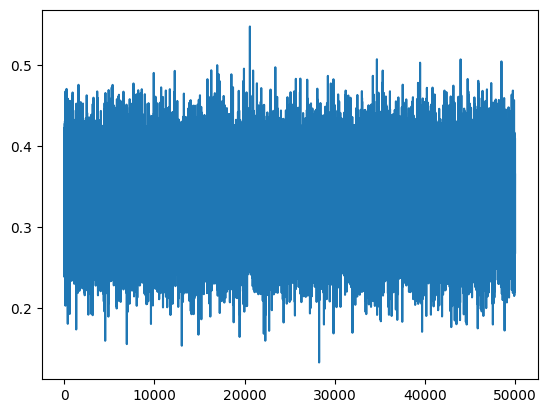

In [280]:
plt.plot(stepi, lossi)

In [281]:
# loss on entire training set
emb = C[Xval]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.2042, grad_fn=<NllLossBackward0>)

In [282]:
# loss on entire training set
emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, yte)
loss

tensor(2.2029, grad_fn=<NllLossBackward0>)

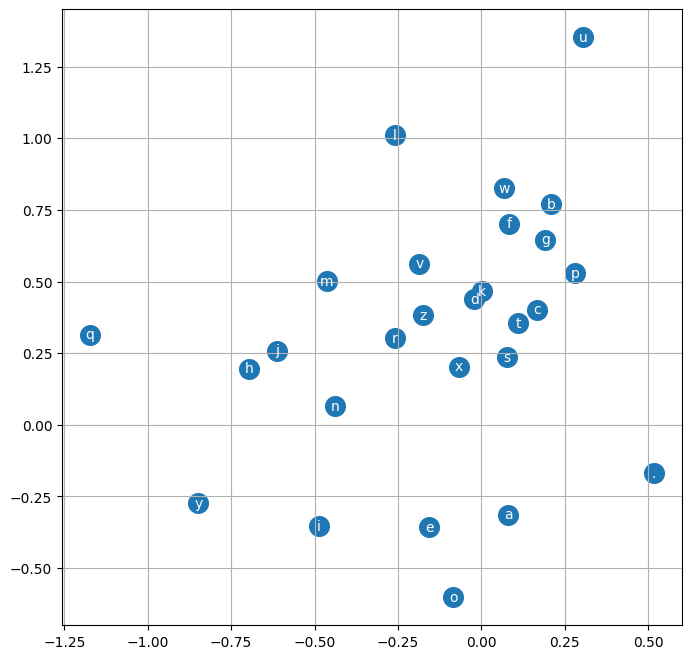

In [264]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha = 'center', va = 'center', color = 'white')
plt.grid('minor')

In [284]:
# sample from the model 

g = torch.Generator().manual_seed(2147483647)
blocksize = 3
for _ in range(20):
    
    out = []
    context = [0] * blocksize # initialize will all ...
    while True:
        emd = C[torch.tensor([context])] # (1,blocksize, d)
        h = torch.tanh(emd.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

junide.
jakasir.
parlayon.
nai.
jirn.
tolet.
sayet.
kalania.
zamilena.
jededainr.
amells.
jainayla.
terinvaumesti.
etume.
ponne.
jah.
jaylino.
aaya.
zon.
kaeland.
